# Elementos de redes neuronales
Este ensayo estará inspirado en [micrograd](https://github.com/karpathy/micrograd) de Andrej Karpathy. En esencia, construiremos una red neuronal desde cero, explicando a detalle cada uno de sus elementos.

```{margin}
*Como prerrequisitos para esta lección, sugiero leer la [lección anterior](https://dantenoguez.github.io/Ensayos/elementos-program.html) y el artículo de Khan Academy sobre la [pendiente matemática](https://es.khanacademy.org/math/cc-eighth-grade-math/cc-8th-linear-equations-functions/8th-slope/a/slope-from-two-points).*
```

En primer lugar, crearemos la «clase» `Numero`, es decir, formularemos una estructura que nos permita definir, modificar y operar con números. Dado que las redes neuronales son gigantescas expresiones matemáticas, los números serán nuestros elementos primarios. De momento, cada número tendrá las siguientes propiedades: un valor, un par de valores previos que pueden generarlo (por ejemplo, 1 y 1 en el caso de que sumados nos den el número 2), la operación que genera al número (en nuestro ejemplo, la suma) y una etiqueta en caso de que queramos asociar nuestro número a una variable. Agregaremos también funciones (suma, resta, etcétera) para operar con nuestros números:

In [ ]:
!pip install matplotlib --upgrade

In [24]:
import math
import matplotlib.pyplot as plt
import numpy as np

In [25]:
class Numero:
  def __init__(self, valor, _previos=(), _op='', etiqueta=''):
    self.valor = valor
    self._previos = set(_previos)
    self._op = _op
    self.etiqueta = etiqueta

  def __add__(self, otro): # adición
    otro = otro if isinstance(otro, Numero) else Numero(otro) # nos cercioramos de que el otro valor sea un Número
    resultado = Numero(self.valor + otro.valor, (self, otro), '+')
    return resultado

  def __radd__(self, otro): # en Python, debemos apoyarnos de una función extra (con prefijo r) para casos en los que la función anterior no funcione
    return self + otro

  def __mul__(self, otro): # multiplicación
    otro = otro if isinstance(otro, Numero) else Numero(otro)
    resultado = Numero(self.valor * otro.valor, (self, otro), '*')
    return resultado

  def __rmul__(self, otro):
    return self * otro

  def __sub__(self, otro): # resta, substracción
    return self + (-otro)

  def __rsub__(self, otro):
    return otro + (-self)

  def __pow__(self, otro):
    assert isinstance(otro, (int, float))
    resultado = Numero(self.valor**otro, (self,), f'**{otro}')
    return resultado

  def __truediv__(self, otro): # división
    return self * otro**-1 #dividir es lo mismo que multiplicar por el dividendo elevado a la menos 1
  
  def __rtruediv__(self, otro):
    return otro * self**-1

  def __neg__(self): # volver negativo un número
    return self * -1

  def __repr__(self):
    return f'Valor={self.valor}' # esta función determina cómo se representa nuestro número


In [26]:
a = Numero(2, etiqueta='a') # definimos dos Números: a y b
b = Numero(5, etiqueta='b')
c = a*b # definimos c, que es el resultado de multiplicar a y b

print(f'{c} | Valores previos: {c._previos}, | Operación realizada para generar c: {c._op}')

Valor=10 | Valores previos: {Valor=2, Valor=5}, | Operación realizada para generar c: *


Antes de pasar a revisar conceptos más complicados, podemos visualizar de mejor manera lo que acabamos de hacer. 
```{margin}
El código para graficar no tiene que ver con las redes neuronales, de manera que queda fuera de nuestro enfoque explicarlo.
```

In [27]:
from graphviz import Digraph

def rastreo(origen):
  # construye un conjunto de todos los nodos en un gráfico
  nodos, lineas = set(), set()
  def construir(v):
    if v not in nodos:
      nodos.add(v)
      for parte in v._previos:
        lineas.add((parte, v))
        construir(parte)
  construir(origen)
  return nodos, lineas

def graficar(origen):
  grafica = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # left to right, izquierda a derecha

  nodos, lineas = rastreo(origen)
  for n in nodos:
    uid = str(id(n))
    # por cada valor en la grafica, crea un nodo rectangular ('record') para él
    grafica.node(name=uid, label='{ %s | valor %.4f}' % (n.etiqueta, n.valor), shape='record')
    if n._op:
      # si el valor es resultado de una operación, crea un nodo para la operación
      grafica.node(name = uid + n._op, label = n._op)
      # conecta los nodos
      grafica.edge(uid + n._op, uid)

  for n1, n2 in lineas:
    # conecta n1 al nodo operación de n2
    grafica.edge(str(id(n1)), str(id(n2)) + n2._op)

  return grafica

Ahora ya podemos graficar los resultados que vimos para la variable $c$:

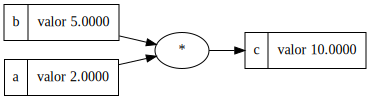

In [28]:
c.etiqueta = 'c'
graficar(c)

Ahora, consideraremos a la función multiplicación como nuestro primer ejemplo para entender las derivadas: en rigor, la derivada es lo mismo que la pendiente, y mide la **proporción del cambio** que una variable provoca en el resultado de una función. En nuestro ejemplo, el cambio que $a$ provoca en el resultado $c$ (o sea $10$), es de cinco veces sí misma. Veámoslo geométricamente para entenderlo mejor:

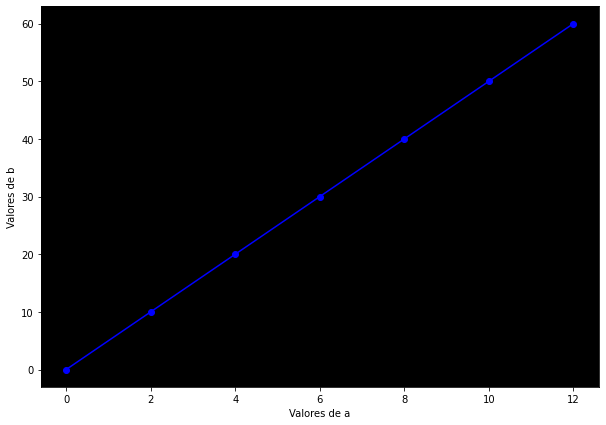

In [53]:
a2 = np.arange(0, 13, 2)
def f(a): return a*5
b2 = f(a2)

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(a2, b2, marker='o', color='blue') 
ax.set_facecolor('black')
ax.set_xlabel('Valores de a')
ax.set_ylabel('Valores de b')
#ax.axline((a2[1], b2[1]), slope=derivada, color='red', label='pendiente')
#ax.hlines(y=16, xmin=0, xmax=4, linewidth=1, color='white', linestyles='dashed')
#ax.vlines(x=4, ymin=0, ymax=16, linewidth=1, color='white', linestyles='dashed')
plt.show()

Hemos asignado más valores a nuestras variables, pero el patrón sigue siendo el mismo: cada $a$ aumenta de dos en dos y se multiplica por cinco. Al final, nuestras correspondencias lucen así:

In [54]:
import pandas as pd
d = {'Valores de a': a2, 'Valores de b': b2}
tabla = pd.DataFrame(data=d)
tabla = tabla.style.hide_index()
tabla

Valores de a,Valores de b
0,0
2,10
4,20
6,30
8,40
10,50
12,60


Lo que la pendiente y la derivada nos señalan, como digo, es cuánto influye $a$ en el valor de $b$: si yo aumento 2 a mi primer valor de $a$, es decir, si paso de 0 a 2, ¿cuánto aumenta $b$? $b$ aumenta 5 veces $a$. Si doy otro paso en $a$, es decir, de 2 a 4. ¿cuánto aumenta $b$? Nuevamente, $b$ aumenta 5 veces $a$: $4 \times 5 = 20$. Así, la derivada de la función $b$ con respecto a $a$ es 5. Trazaremos la derivada para entenderlo:

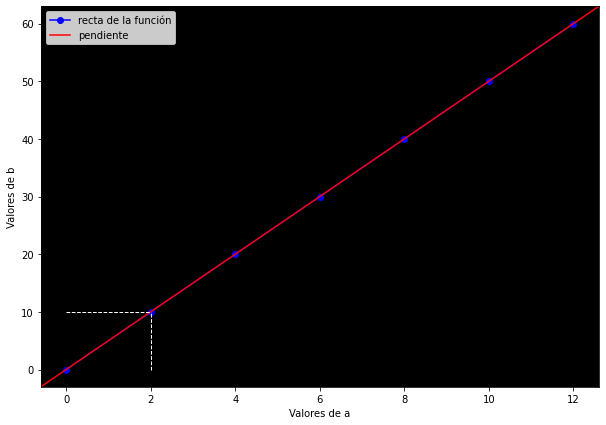

In [51]:
a2 = np.arange(0, 13, 2)
def f(a): return a*5
b2 = f(a2)

derivada = (b2[2] - b2[1]) / (a2[2] - a2[1])

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(a2, b2, marker='o', color='blue', label='recta de la función') 
ax.set_facecolor('black')
ax.set_xlabel('Valores de a')
ax.set_ylabel('Valores de b')
ax.axline((a2[1], b2[1]), slope=derivada, color='red', label='pendiente') # <- Aquí está definida la derivada
ax.hlines(y=10, xmin=0, xmax=2, linewidth=1, color='white', linestyles='dashed')
ax.vlines(x=2, ymin=0, ymax=10, linewidth=1, color='white', linestyles='dashed')
ax.legend()
plt.show()

Veamos ahora un ejemplo con la función suma: mi variable $x$ tendrá valores del 0 al al 12 con intervalos de 2, mientras que mi función es $x+6$. Mi tabla de valores entonces debería quedar así:

In [58]:
x = np.arange(0, 13, 2)
def f(x): return x+6
y = f(x)

z = {'Valores de x': x, 'Valores de y': y}
tabla = pd.DataFrame(data=z)
tabla = tabla.style.hide_index()
tabla

Valores de x,Valores de y
0,6
2,8
4,10
6,12
8,14
10,16
12,18


Ahora preguntémonos: ¿en qué proporción cambia $y$ cuando aumentamos $x$? Si paso de mi primer valor de $x$ al segundo, es decir, si aumento 2 al 0, ¿cuánto estoy aumentando a mi primer valor de $y$? ¡También dos! Es decir, que la proporción de los cambios entre $x$ e $y$ es 1: si aumento dos a $x$, también aumento 2 a $y$. Anteriormente, si agregábamos 2 a $a$, nuestro valor de $b$ aumentaba cinco veces.

Grafiquemos nuestra nueva función de suma:

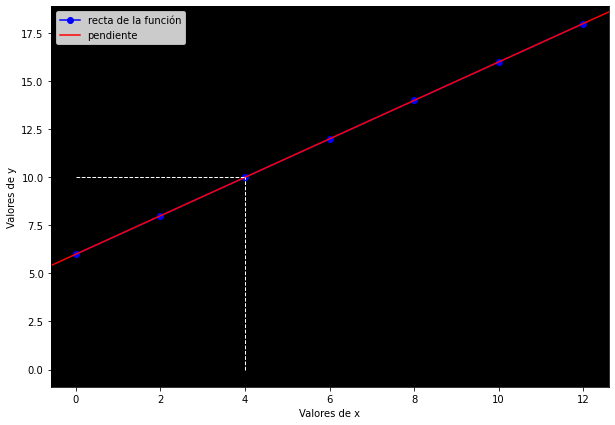

In [55]:
derivada = (y[2] - y[1]) / (x[2] - x[1])

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(x, y, marker='o', color='blue', label='recta de la función') 
ax.set_facecolor('black')
ax.set_xlabel('Valores de x')
ax.set_ylabel('Valores de y')
ax.axline((x[1], y[1]), slope=derivada, color='red', label='pendiente') # <- Aquí está definida la derivada
ax.hlines(y=10, xmin=0, xmax=4, linewidth=1, color='white', linestyles='dashed')
ax.vlines(x=4, ymin=0, ymax=10, linewidth=1, color='white', linestyles='dashed')
ax.legend()
plt.show()

Ahora ya entendemos conceptualmente los términos «derivada» y «pendiente», que en realidad son lo mismo. Estudiemos brevemente las fórmulas, para ver cómo se refleja nuestro concepto en ellas:

Una fórmula de la derivada luce así:
$$
f^{\prime}(a)=\lim _{h \rightarrow 0} \frac{f(a+h)-f(a)}{h}
$$

Otra fórmula luce así:
$$
\frac{\partial f(x, y)}{\partial x}=\frac{f(x+h, y)-f(x, y)}{h}
$$

Y la fórmula de la pendiente:
$$
\text { Pendiente }=\frac{\text { Cambio en } \mathrm{y}}{\text { Cambio en } \mathrm{x}}
$$

O también:
$$
\text { Pendiente }=\frac{\Delta \mathrm{y}}{\Delta \mathrm{x}}
$$

```{margin}
Sobre límites se puede leer [este artículo](https://es.khanacademy.org/math/ap-calculus-ab/ab-limits-new/ab-1-2/a/limits-intro?modal=1); sobre derivadas, [estos videos](https://es.khanacademy.org/math/ap-calculus-ab/ab-differentiation-1-new).
```

Es importante familiarizarnos con los símbolos para identificar estos conceptos y fórmulas en los textos académicos. Los signos $\delta, \Delta$ son letras del alfabeto griego llamadas «delta», y generalmente se utilizan para representar un cambio. El símbolo $\lim _{h \rightarrow 0}$ significa «el límite de la función cuando $h$ tiende a 0»

Todas estas fórmulas significan lo mismo. En Wikipedia, se define a la derivada de una función como una «razón de cambio instantánea con la que varía el valor de dicha función matemática», según se modifique el valor de su variable independiente. En otras palabras, es lo que decíamos: la derivada mide la proporción (o razón, o tasa) del cambio que una variable provoca en la función.

Por completitud, podemos utilizar estas fórmulas matemáticas para demostrar que son equivalentes entre sí, demostrando a la vez que nuestros resultados programáticos son correctos.